# 1. Importing of essential modules/libraries

In [174]:
import numpy as np
import librosa
import math
import re
import os
import sys
import time
import math
from keras.models import Sequential, load_model
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflowjs as tfjs
import IPython.display as ipd
from IPython.display import clear_output
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

# 2.Creating a library, which allows to extract features from files in directories

In [152]:
class AudioDataGenerator:
    
    """Function just for testing. Modify it for your own needs(mainly just path)"""
    def count_files(self):
        counter = 0
        for directory in os.listdir(".\\dataset3\\audio"):
            for file in os.listdir(".\\dataset3\\audio\\" + directory):
                counter = counter + 1
        return counter
    
    def flow_from_directory(self,dir_path):
        file_number = self.count_files()
        print("Found {} files".format(file_number))
        
        """All parameters needed for the future"""
        
        labels = []
        data = []
        counter = 0
        cat_counter = 0
        timeseries_length = 16
        hop_length = 512
        percentage_counter = 1
        step_counter = 1
        data = np.zeros((file_number, timeseries_length, 33), dtype=np.float64)
          
        start_time = time.time()
        
        for directory in os.listdir(dir_path):
            category = directory
            cat_counter = cat_counter + 1
            for file in os.listdir(dir_path +"\\"+category):
                y, sr = librosa.load(os.getcwd() + "\\" + dir_path + "\\" + category +"\\" + file)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length= hop_length, n_mfcc= 13)
                spectral_center = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length= hop_length)
                chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
                spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length= hop_length)
                
                data[counter, :, 0:13] = mfcc.T[0:timeseries_length, :]
                data[counter, :, 13:14] = spectral_center.T[0:timeseries_length, :]
                data[counter, :, 14:26] = chroma.T[0:timeseries_length, :]
                data[counter, :, 26:33] = spectral_contrast.T[0:timeseries_length, :]
                
                elapsed_time = time.time() - start_time
                
                counter = counter + 1 #represents the number of files that have been extracted
                
                labels.append(category)
                percentage = counter / file_number
                
                current_step = file_number * 0.05 * step_counter
                files_per_second = counter // elapsed_time
                
        
                if counter >= current_step:
                    clear_output()
                    #print("{} - {}".format(counter, current_step)) #Helping line while coding
                    self.animate_extraction(percentage, files_per_second)
                    step_counter = step_counter + 1
        
        
        print("Extracted {} files from {} categories".format(counter, cat_counter ))
        return data, np.expand_dims(np.asarray(labels), axis=1)
       
    """Extracting features of a single file. To test&check how a current model is working"""  
    
    def test_sample(self, filename):
                timeseries_length = 16
                hop_length = 512
                data = np.zeros((1, timeseries_length, 33), dtype=np.float64)
            
                y, sr = librosa.load(os.getcwd() + "\\dataset3\\test\\"+ filename)
                mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length= 512, n_mfcc= 13)
                spectral_center = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length= hop_length)
                chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
                spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=hop_length)
                
                data[0, :, 0:13] = mfcc.T[0:timeseries_length, :]
                data[0, :, 13:14] = spectral_center.T[0:timeseries_length, :]
                data[0, :, 14:26] = chroma.T[0:timeseries_length, :]
                data[0, :, 26:33] = spectral_contrast.T[0:timeseries_length, :]
                
                
                return data
            
    """A simple method to visualise the rate of extracting features.
        Not directly related to the meaning of the rest of the code."""
    
    def animate_extraction(self, percentage, files_per_second):
        sys.stdout.write("[")
        total_num_signs = 20 #Max number of hashes is 20. We refresh the bar every 5%
        hash_num = math.floor(percentage*total_num_signs) #Current number of hashes.
        
        for i in range(0, hash_num):
            sys.stdout.write("#")
        for i in range(0, total_num_signs - hash_num):
            sys.stdout.write("-")

        sys.stdout.write("] ")
        sys.stdout.write("{}% Average:{} files per second\n\n".format(int(percentage * 100), int(files_per_second)))

# 3.Preprocessing data & feature extraction

## 3.1 Using function to extract numpy arrays 

In [153]:
generator = AudioDataGenerator()
#generator.count_files() #info about the number of all files(except directories) in all directiories in our path

X_train, y_train = generator.flow_from_directory("dataset3\\audio") #Extraction features, got almost ready datasets

[####################] 100% Average:22 files per second

Extracted 2080 files from 2 categories


In [154]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [155]:
lbl_enc = LabelEncoder()

y_train_enc = lbl_enc.fit_transform(y_train)
y_valid_enc = lbl_enc.transform(y_valid)

y_train_enc = np.ravel(y_train_enc)
y_valid_enc = np.ravel(y_valid_enc)

y_train_enc = to_categorical(y_train_enc, 2)
y_valid_enc = to_categorical(y_valid_enc, 2)

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# 4.Creating a model

# 4.1 The architecture of the model

In [160]:
model = Sequential()
model.add(LSTM(units=128, dropout=0.01, recurrent_dropout=0.1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=64, dropout=0.01, recurrent_dropout=0.1, return_sequences=False))
model.add(Dense(units= 128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units= 128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units= 128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units= 2, activation='sigmoid'))

# 4.2 Compilation

In [ ]:
model.compile(optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"])

# 5.Training process

In [162]:
process_history = model.fit(
        X_train,
        y_train_enc,
        epochs = 10,
        steps_per_epoch = 1664// 16,
        validation_data = (X_valid, y_valid_enc),
        validation_steps = 416 // 16
)

Train on 1664 samples, validate on 416 samples
Epoch 1/10
104/104 [==============================] - 91s 874ms/step - loss: 0.5132 - acc: 0.7157 - val_loss: 0.5445 - val_acc: 0.6995
Epoch 2/10
104/104 [==============================] - 88s 851ms/step - loss: 0.3809 - acc: 0.7934 - val_loss: 0.6464 - val_acc: 0.7043
Epoch 3/10
104/104 [==============================] - 84s 811ms/step - loss: 0.3052 - acc: 0.8370 - val_loss: 0.7228 - val_acc: 0.7163
Epoch 4/10
104/104 [==============================] - 83s 801ms/step - loss: 0.2605 - acc: 0.8632 - val_loss: 0.7634 - val_acc: 0.7476
Epoch 5/10
104/104 [==============================] - 85s 821ms/step - loss: 0.2261 - acc: 0.8851 - val_loss: 0.7900 - val_acc: 0.7163
Epoch 6/10
104/104 [==============================] - 85s 818ms/step - loss: 0.1981 - acc: 0.9023 - val_loss: 0.7877 - val_acc: 0.7596
Epoch 7/10
104/104 [==============================] - 85s 814ms/step - loss: 0.1795 - acc: 0.9119 - val_loss: 0.9407 - val_acc: 0.7380
Epoch 8/

# 6.Saving the trained model to a file

In [163]:
model.save("./model/yes_or_no.h5") # Optional

# 7. Loading from an external file

In [164]:
model = load_model("./model/yes_or_no.h5") # Optional

# 8. Testing section. Playground

### 8.1 Enter a filename. (If your filepath is different from the repo, change it directly in code)

In [165]:
generator = AudioDataGenerator()

test_sample = generator.test_sample("myno.wav")

### 8.2 Predicting what out file plays

In [166]:
preds = model.predict(test_sample)

In [167]:
preds #printing out the results. First coefficient is related to "yes", the second one to "no"

array([[9.999999e-01, 4.340293e-10]], dtype=float32)

### 8.3 Play

In [209]:
ipd.Audio('./dataset3/test/no_1.wav') # load a local WAV file

## 8.4 Visualisation

### 8.4.1 Raw data from a file. Time to Amplitude

In [214]:
x, sr = librosa.load('./dataset3/test/no_1.wav') # extract features
#x, index = librosa.effects.trim(x) #trimming/getting rid of "0 amplitude areas"
#print(librosa.get_duration(x), librosa.get_duration(x))

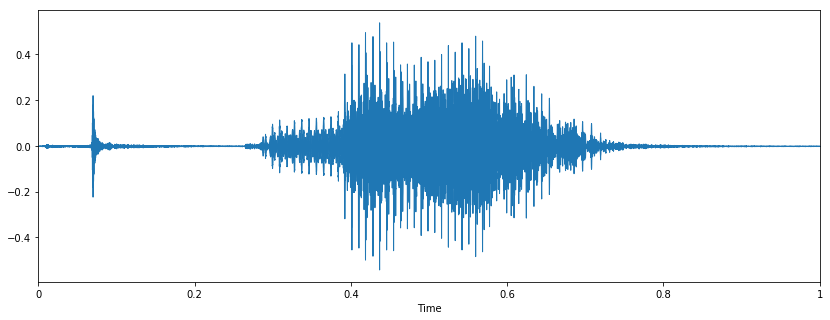

In [215]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)

### 8.4.2 Spectrogram

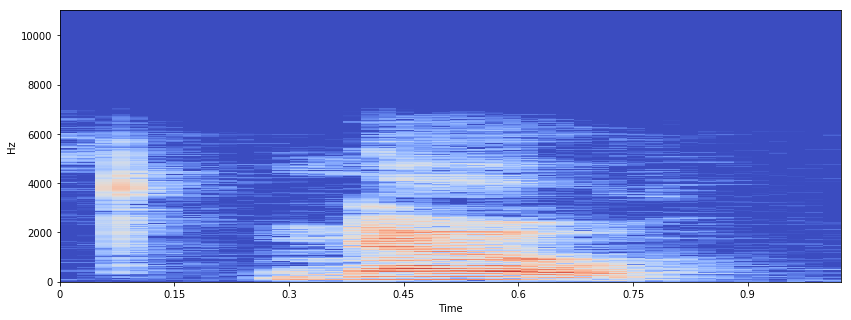

In [219]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')